Assignment part 3

In [1]:
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import KFold
import seaborn as sn
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
# !pip install tensorflow

# New Section

In [3]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\cheta\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\cheta\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [4]:
tagged_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')
print(tagged_sentences[1])

[('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('of', 'ADP'), ('Atlanta', 'NOUN'), ("''", '.'), ('for', 'ADP'), ('the', 'DET'), ('manner', 'NOUN'), ('in', 'ADP'), ('which', 'DET'), ('the', 'DET'), ('election', 'NOUN'), ('was', 'VERB'), ('conducted', 'VERB'), ('.', '.')]


In [5]:
X_sentence = []
Y_sentence = []

for sentence in tagged_sentences:
  X_sen = []
  Y_sen = []
  for i in sentence:
    X_sen.append(i[0])
    Y_sen.append(i[1])

  X_sentence.append(X_sen)
  Y_sentence.append(Y_sen)

num_words = len(set([word.lower() for sentence in X_sentence for word in sentence]))
tag_list = set([word for sentence in Y_sentence for word in sentence])
num_tags = len(tag_list)

In [6]:
# print(tag_list,num_tags)
# print(num_words,num_tags)
# print(X[0])
# print(Y[0])

In [7]:
# print(len(X[0]))

In [8]:
# print(X_sentence[0:5])

**Word Encoding into numbers**

In [9]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(X_sentence) 
X_encoded = word_tokenizer.texts_to_sequences(X_sentence)

tag_tokenizer = tf.keras.preprocessing.text.Tokenizer()
tag_tokenizer.fit_on_texts(Y_sentence)
Y_encoded = tag_tokenizer.texts_to_sequences(Y_sentence)


In [10]:
print(X_encoded[1])
print(Y_encoded[0])

[1, 1634, 439, 62, 8, 27806, 27807, 9, 1, 238, 2028, 602, 2, 37, 27, 3107, 861, 4, 1, 1401, 2, 14, 5685, 1, 5434, 5, 2954, 4, 1, 238, 4, 3108, 15, 13, 1, 850, 8, 37, 1, 1401, 11, 2029, 3]
[5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3]


In [11]:
# maxe = 0
# ind = 0
# for x in X_encoded:
#   maxe = max(maxe,len(x))
# print(maxe)

In [12]:
MAX_SENTENCE_LENGTH = 180
def padding_sentence(X_encoded,Y_encoded):
  X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=MAX_SENTENCE_LENGTH, padding="pre", truncating="post")
  Y_padded = tf.keras.preprocessing.sequence.pad_sequences(Y_encoded,maxlen=MAX_SENTENCE_LENGTH,padding="pre",truncating="post")
  Y_padded = tf.keras.utils.to_categorical(Y_padded)
  return X_padded,Y_padded

In [13]:
# t1,t2 = padding_sentence(X_encoded,Y_encoded)
# print(len(Y_encoded[342]))
# print(Y_sentence[342])
# # print(key_tag_map)
# print(t2[342][144:180])
# print(len(X_padded[0]))
# print(len(word_tokenizer.word_index))

In [14]:
import gensim.downloader as api

#online loading from api
from gensim.models import KeyedVectors
path = "./GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

#local loading
# word2vec = api.load('word2vec-google-news-300')

In [15]:
EMBEDDING_SIZE = 300
VOCABULARY_SIZE = len(word_tokenizer.word_index)+1
embedding_weights = np.zeros((VOCABULARY_SIZE,EMBEDDING_SIZE))
word2vec_id = word_tokenizer.word_index
for word,index in word2vec_id.items():
  try:
    embedding_weights[index,:] = word2vec[word]
  except KeyError:
    pass

In [16]:
# print(word_tokenizer.word_index.items())

In [17]:
# print(Y[0:10])
# from keras.utils import to_categorical
# X = X_padded
# Y = tf.keras.utils.to_categorical(Y_padded)
NUM_CLASSES = 13

In [18]:
def getmodel():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(input_dim = VOCABULARY_SIZE, 
  output_dim = EMBEDDING_SIZE, 
  input_length = MAX_SENTENCE_LENGTH,
  weights=[embedding_weights], 
  trainable = True
  ))
  model.add(tf.keras.layers.Dense(128,activation='relu'))
  model.add(tf.keras.layers.Dense(64,activation='relu'))
  model.add(tf.keras.layers.Dense(NUM_CLASSES,activation='softmax'))
  model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['accuracy'])
  return model

In [19]:
def unknown_word_handle(words):
  known_sentence = []
#   c=0
  for sentence in words:
#     if c%50==0:
#       print(c)
    new_sentence=[]
    for word in sentence:
      if word in flat_X_sentence:
        new_sentence.append(word)
      else:
        if word in word2vec:
          my_vec = word2vec[word]
          max_value=-200
          sim_word='X'
          for wrd,vec in X_word_vectors.items():
            cos_value=cosine_similarity(my_vec.reshape(1,my_vec.shape[0]),vec.reshape(1,vec.shape[0]))
            if(max_value<cos_value):
              max_value=cos_value
              sim_word=wrd
          new_sentence.append(sim_word)
        else:
          new_sentence.append('de')
    known_sentence.append(new_sentence)
  return known_sentence

In [20]:
flat_X_sentence = set([item for sublist in X_sentence for item in sublist])
X_word_vectors={}
for word in flat_X_sentence:
  if(word in word2vec):
    X_word_vectors[word]=word2vec[word]

In [21]:

def plotcm(conf):
  tg_lst = np.array(list(tag_list))

  for val,key in tag_tokenizer.word_index.items():
    tg_lst[key-1] = val
  precision_matrix = np.diagonal(conf/np.sum(conf,axis=0))
  recall_matrix = np.diagonal(conf/np.sum(conf,axis=1))
  F1_matrix = 2*precision_matrix*recall_matrix/(precision_matrix+recall_matrix)
  print(precision_matrix)
  print(recall_matrix)
  print(F1_matrix)

  b = tg_lst
#   b = b[b!='$']
  df_cm = pd.DataFrame(conf, index = [i for i in b.tolist()],columns = [i for i in b.tolist()])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm/np.sum(df_cm), annot = True, cmap = plt.cm.Blues)
  plt.show()

Epoch 1/5
359/359 [==============================] - 79s 216ms/step - loss: 0.2297 - accuracy: 0.9828
Epoch 2/5
359/359 [==============================] - 80s 223ms/step - loss: 0.0139 - accuracy: 0.9945
Epoch 3/5
359/359 [==============================] - 82s 227ms/step - loss: 0.0127 - accuracy: 0.9948
Epoch 4/5
359/359 [==============================] - 82s 229ms/step - loss: 0.0123 - accuracy: 0.9948
Epoch 5/5
359/359 [==============================] - 3s 7ms/step
Accuracy of  1 0.9454625339511104
Epoch 1/5
359/359 [==============================] - 82s 225ms/step - loss: 0.2178 - accuracy: 0.9827
Epoch 2/5
359/359 [==============================] - 81s 225ms/step - loss: 0.0138 - accuracy: 0.9945
Epoch 3/5
359/359 [==============================] - 81s 225ms/step - loss: 0.0126 - accuracy: 0.9948
Epoch 4/5
359/359 [==============================] - 81s 226ms/step - loss: 0.0122 - accuracy: 0.9949
Epoch 5/5
359/359 [==============================] - 2s 7ms/step
Accuracy of  2 0.942

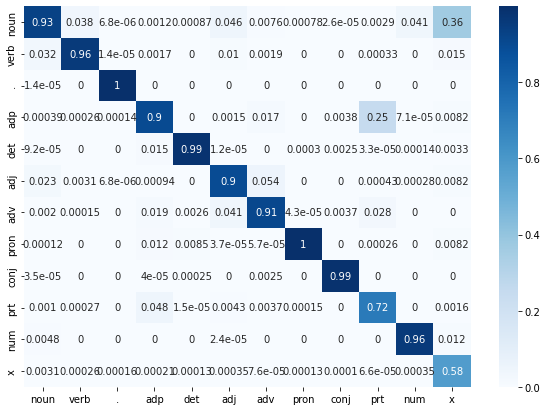

In [22]:
# from scipy.linalg.special_matrices import tri
kfold = KFold(n_splits=5, random_state=None, shuffle=False)
# print(kfold.split(X))
max_accuracy = 0
accuracy = 0
num_fold = 1
# print(X[0])
# print(Y[0])
X_processed,Y_processed = padding_sentence(X_encoded,Y_encoded)
X = np.array(X_processed)
Y = np.array(Y_processed)
final_confusion_matrix = np.zeros((num_tags,num_tags))
# def train():
for train_index,test_index in kfold.split(X,Y):
  # print(len(train_index))
  # print(len(test_index))
  X_train = X[train_index]  
  X_test = X[test_index]
  Y_train = Y[train_index]
  Y_test = Y[test_index]
  model = getmodel()
  model.fit(X_train, Y_train, batch_size=128, epochs=5,verbose=1)
  X_test_sentence = []
# 
#   for i in test_index:
#     new_sentence = unknown_word_handle([X_sentence[i]])
#     X_test_sentence+=new_sentence
#   X_test_sentence = (unknown_word_handle(X_sentence[test_index]))
#   X_test = word_tokenizer.texts_to_sequences(X_test_sentence)
#   X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SENTENCE_LENGTH, padding="pre", truncating="post")
#   X_test = np.array(X_test)
# 
  y_pred = model.predict(X_test)
  # print(y_pred)
  y_true_truc = []
  y_pred_truc = []
#   nz=0
  for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      if X_test[i,j]!=0:
        y_true_truc.append(np.where(Y_test[i,j]==1)[0][0]-1)
        
        ind = np.where(y_pred[i,j] == np.amax(y_pred[i,j]))[0][0]
        # print(ind)
        if ind==0:
#           nz+=1
          y_pred_truc.append(2)
        else:
          y_pred_truc.append(ind-1)
#######
#   tt=0
#   pt=0
#   pf=0
#   # print(len(y_true_truc))
#   assert np.array(y_true_truc).all()>=0 and np.array(y_true_truc).all()<=11
#   for p,t in zip(y_true_truc,y_true_truc):
#     if t==11:
#       tt+=1
#       if p == 11:
#         pt+=1
#       else:
#         pf+=1
#   print(tt,pt,pf,nz)
#########
#   print(len(y_pred_truc))
#   plotcm(confusion_matrix(y_true_truc,y_pred_truc))
  final_confusion_matrix += confusion_matrix(y_true_truc,y_pred_truc)
  accuracy = accuracy_score(y_true_truc,y_pred_truc,normalize=True)
  print("Accuracy of ",num_fold,accuracy)
  if max_accuracy<accuracy:
    max_accuracy = accuracy
    final_model = model
  num_fold += 1

plotcm(final_confusion_matrix/5)

In [23]:
# print(X_test_sentence[0:10])
tt=0
pt=0
pf=0
# print(len(y_true_truc))
assert np.array(y_true_truc).all()>=0 and np.array(y_true_truc).all()<=11
for p,t in zip(y_true_truc,y_true_truc):
    if t==11:
        tt+=1
        if p is 11:
            pt+=1
        else:
            pf+=1
print(tt,pt,pf)

181 0 181


<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\cheta\AppData\Local\Temp\ipykernel_17764\1769689768.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if p is 11:


In [24]:
# print(y_pred.shape)
# print(np.where(Y_test[15][179]==1)[0][0])
# for val,key in tag_tokenizer.word_index.items():
#   print(val,key)
# print(model)
# print(Y_test)
print(test_index)
# print(X_sentence[test_index])
a = [1,2,3,4]
b = [2,3]
a.append(b)
print(a)

[45872 45873 45874 ... 57337 57338 57339]
[1, 2, 3, 4, [2, 3]]


In [25]:
# for i in y_pred_truc:
#   print(i)
#   if i>=1 and i<=12:
#     pass
#   else:
#     print(i)

In [26]:
# accuracy = accuracy_score(y_true_truc,y_pred_truc,normalize=True)

In [27]:
# print(y_true_truc[1:10])
# print(y_pred_truc[1:10])

In [28]:
# print(accuracy)
# print(y_pred[0][170:180])
# print(np.amax(y_pred[0][179]))
# print(len(y_pred_truc))

In [29]:
# wv = keyedvectors.load_word2vec_format(path, binary=True)

In [30]:
def predict(X,model,tag_tokenizer,word_tokenizer):
  X = unknown_word_handle(X)
  X_encoded = word_tokenizer.texts_to_sequences(X)
  X_test = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=MAX_SENTENCE_LENGTH, padding="pre", truncating="post")
  y_pred = model.predict(X_test)
  # y_true_truc = []
  # y_pred_truc = []
  X_tagged = []
  key_tag_map = dict()
  y_pred = model.predict(X_test)
  for val,key in tag_tokenizer.word_index.items():
    key_tag_map[key] = val
  for i in range(X_test.shape[0]):
    X_temp_tag = []
    for j in range(X_test.shape[1]):
      if X_test[i,j]!=0:
        # y_true_truc.append(np.where(Y_test[i,j]==1)[0][0])
        ind = np.where(y_pred[i,j] == np.amax(y_pred[i,j]))[0][0]
        # print(ind)
        if ind==0:
          ind = 2
        X_temp_tag.append(key_tag_map[ind].upper())
    X_tagged.append(X_temp_tag)
  return X_tagged
        
      

In [31]:
# X_tagged = predict(X_test,final_model,tag_tokenizer)

In [32]:

# print(len(X_tagged[0]))
# print(len(Y_sentence[0]))
# ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']

In [33]:
key_tag_map = dict()

for val,key in tag_tokenizer.word_index.items():
    key_tag_map[key] = val
print(key_tag_map)

{1: 'noun', 2: 'verb', 3: '.', 4: 'adp', 5: 'det', 6: 'adj', 7: 'adv', 8: 'pron', 9: 'conj', 10: 'prt', 11: 'num', 12: 'x'}


In [34]:
print(len(flat_X_sentence),word2vec['Chetan'].shape)
max_value=-200
my_vec=word2vec['noun']
sim_word='X'
for wrd,vec in X_word_vectors.items():
  cos_value=cosine_similarity(my_vec.reshape(1,my_vec.shape[0]),vec.reshape(1,vec.shape[0]))
  if(max_value<cos_value):
    max_value=cos_value
    sim_word=wrd
sim_word

56057 (300,)


'noun'

In [35]:
print(key_tag_map)

{1: 'noun', 2: 'verb', 3: '.', 4: 'adp', 5: 'det', 6: 'adj', 7: 'adv', 8: 'pron', 9: 'conj', 10: 'prt', 11: 'num', 12: 'x'}


In [36]:
t = [['Nikhil','is','happy']]
print(unknown_word_handle(t))
t = unknown_word_handle(t)
predicted_tag = predict(t,final_model,tag_tokenizer,word_tokenizer)
print(predicted_tag)

[['Das', 'is', 'happy']]
1/1 [==============================] - 0s 19ms/step
[['X', 'VERB', 'ADJ']]


In [37]:
word_tokenizer.texts_to_sequences(t)
# print(t)

[[24733, 10, 1102]]

In [38]:
print(X_sentence[0:5])
# print(np.array(X_sentence).flatten())
print(Y_sentence[0])

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'Mayor-nominate', 'Ivan', 'Allen', 'Jr.', '.'], ['``', 'Only', 'a', 'relative', 'handful', 'of', 'such', 'rep

In [39]:
temp=[]
c=0
for x,y in zip(X_sentence,Y_sentence):
    for wo,ta in zip(x,y):
        if wo=='de':
          print(wo)
          print(c)
    c+=1

de
342
de
3328
de
3640
de
3641
de
3654
de
4240
de
6557
de
8698
de
8699
de
8965
de
8966
de
8966
de
13604
de
13610
de
15210
de
17217
de
17460
de
17512
de
19817
de
19875
de
23135
de
24737
de
25939
de
26095
de
26095
de
26211
de
26261
de
32874
de
32898
de
32898
de
32948
de
32948
de
32949
de
32949
de
33914
de
33937
de
40492
de
42055
de
42072
de
42076
de
42090
de
42094
de
42099
de
47011
de
54707
de
57171
de
57228
de
57331


In [40]:
# import statistics
# res = statistics.mode(temp)
      
# # printing result
# print ("Most frequent number is : " + str(res))
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 300)          14944800  
                                                                 
 dense (Dense)               (None, 180, 128)          38528     
                                                                 
 dense_1 (Dense)             (None, 180, 64)           8256      
                                                                 
 dense_2 (Dense)             (None, 180, 13)           845       
                                                                 
Total params: 14,992,429
Trainable params: 14,992,429
Non-trainable params: 0
_________________________________________________________________
